# Working with Projections

[Projections](https://en.wikipedia.org/wiki/Map_projection) are ``geoplot``'s killer feature. Our explaination is by example. Throughout this segment of the tutorial we'll use the `polyplot` plot type, which faithfully displays whatever geometry put into it.

## Projection and unprojection

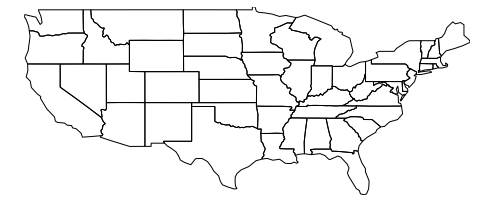

In [1]:
import geopandas as gpd
import geoplot as gplt
%matplotlib inline

from quilt.data.ResidentMario import geoplot_data
contiguous_usa = gpd.read_file(geoplot_data.contiguous_usa())

gplt.polyplot(contiguous_usa).set_aspect("equal")

This map is an example of an unprojected plot: it reproduces our coordinates as if they were on a flat Cartesian plane. But remember, the Earth is not a flat surface; it's a sphere. This isn't a map of the United States that you'd seen in print anywhere because it badly distorts both of the [two criteria](http://www.geo.hunter.cuny.edu/~jochen/gtech201/lectures/lec6concepts/Map%20coordinate%20systems/How%20to%20choose%20a%20projection.htm) most projections are evaluated on: *shape* and *area*. 

For sufficiently small areas, the amount of distortion is very small. This map of New York City, for example, is reasonably accurate:

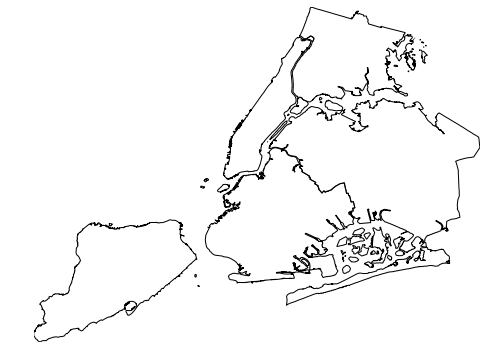

In [2]:
boroughs = gpd.read_file(geoplot_data.nyc_boroughs())

gplt.polyplot(boroughs)

More consequentially, ``geoplot`` returns unprojected plots as pure ``matplotlib`` ``AxesSubplot`` objects, while projected plots, which require heavy-lifting in the form of coordinate transformations, are returned as ``cartopy`` ``GeoAxesSubplot`` objects. To understand why this matters, let's first take a look at how we generate projected plots, and what they look like.

In the case of the contiguous United States, the projection most often used is known as the [Albers Equal Area projection](https://en.wikipedia.org/wiki/Albers_projection). This projection works by wrapping the Earth around a cone, one that's particularly well optimized for locations near the middle of the Northern Hemisphere (and particularly poorly for locations at the poles).

To place our plot in a projection, we need to pass the projection of interest to the `projection` keyword parameter. ``geoplot`` functions expect input to come from the `geoplot.crs` module, imported as ``gcrs`` by convention.

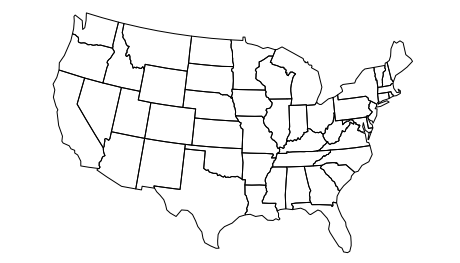

In [3]:
import geoplot.crs as gcrs

gplt.polyplot(contiguous_usa, projection=gcrs.AlbersEqualArea())

``geoplot`` projections are actually a very thin wrapper on ``cartopy.crs`` projections, and every ``cartopy`` projection is implemented in ``geoplot.crs``. Refer to [this page](http://scitools.org.uk/cartopy/docs/latest/crs/projections.html) to see the list of projections that ``geoplot`` implements.

<!--
You may be wondering, if ``geoplot.crs`` is a wrapper on ``cartopy.crs``, why not just use Cartopy CRS objects directly? This comes down to an important implementation detail: when Cartopy CRS objects are used as the library  intends for them to be used, projection geolocation settings are supposed to be defined as parameters to the projection and cannot be modified after instantiation. This means that if you don't explicitly specify otherwise yourself, a Cartopy CRS object will result in a map centered on mid-Africa&mdash;coordinate `(0, 0)`!</p>

``geoplot`` avoids forcing this extra work on the user by computing sensible defaults, based on the data provided, when exact settings are not provided. This is why the plot above "just works": ``geoplot`` computed the mean centroid of the polygons and centered the plot on that coordinate in the background. This feature comes at the cost of a little bit of awkwardness, requiring our wrapper classes, but overall the tradeoff seems to be very "worth it".</p>
-->

At this time, the defaults are still a work in progress, however. If you look closely at this figure you'll notice that our copy of the United States is ever so slightly skewed downwards and to the right, indicating that the default settings ``geoplot`` calculates for us are off. We can correct this by specifying center coordinates ourselves.

The [center of the contiguous United States](https://en.wikipedia.org/wiki/Geographic_center_of_the_contiguous_United_States) is 39°50′N 98°35′W. If we provide approximately these coordinates as `central_latitude` and `central_longitude` coordinates to our projection, our skew is fixed!

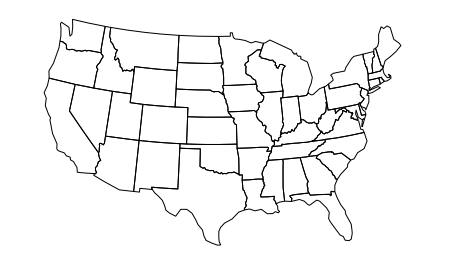

In [5]:
gplt.polyplot(contiguous_usa, 
              projection=gcrs.AlbersEqualArea(central_longitude=-98, 
                                              central_latitude=39.5))

This is the version of the map of the United States that you're probably most familiar with.

## Tips and tricks

``geoplot`` comes with most of the projections provided by ``cartopy`` built-in. Of particular value are global projections, which provide a way of visualizing your data on top of an actual sphere:

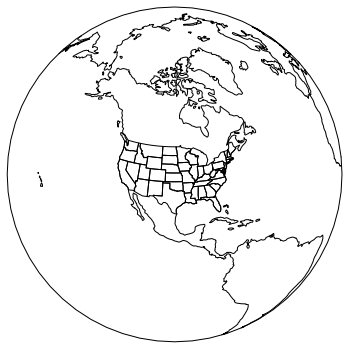

In [13]:
ax = gplt.polyplot(contiguous_usa, 
                   projection=gcrs.Orthographic(central_longitude=-98))
ax.set_global()
ax.outline_patch.set_visible(True)
ax.coastlines()
# ax.stock_img()

This example also generates another ``cartopy`` feature: the fact that ``cartopy`` has several different low-resolution geographies built-in. In this case, we also tossed the world coastlines onto the map. Also note the use of `set_global` here to quickly set the plotting context to the entire world.

To see more like this, check out the [Los Angeles Flights](../../examples/los-angeles-flights.html) example in the Gallery.

Now, recall that ``geoplot`` returns unprojected plots as pure ``matplotlib`` ``AxesSubplot`` objects, while projected plots are returned as ``cartopy`` ``GeoAxesSubplot`` objects. But ``cartopy`` ``GeoAxesSublot`` objects cannot be colocated with ``matplotlib`` ``AxesSubplot`` objects, nor vice versa!  Once you have a graph, you're stuck in whatever "ecosystem" you chose to be in at runtime. This is the major reason why we even bother providing an option to get "inferior-looking" ``AxesSubplot`` output at all: because it can integrated with other "stuff" in the wider ``matplotlib`` ecosystem.

For example, consider the ``mplleaflet`` library. ``mplleaflet`` is a small library which allows you to place ``matplotlib`` plots on an interactive [Leaflet](http://leafletjs.com/) webmap:

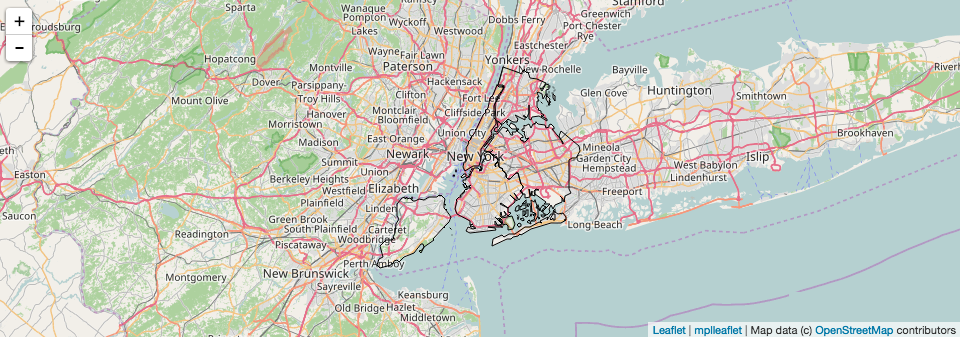

In [26]:
import mplleaflet
gplt.polyplot(boroughs)
mplleaflet.show()
pass

from IPython.display import Image
Image("./figures/leaflet-webmap-example.png")

Unfortunately the interactive won't display in a Jupyter Notebook distributed on the web, so he's a static image instead. But you can see the interactive in all of its glory [by following this link](http://bl.ocks.org/ResidentMario/868ac097d671df1ed5ec83eed048560c).

This is obviously a neat little hack that is sure to come in handy!

## Further reading

The [list of available projections](http://scitools.org.uk/cartopy/docs/latest/crs/projections.html), courtesy of ``cartopy``. Just remember that when using these in ``geoplot``, replace `cartopy.crs` with `geoplot.crs`.